In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import pyro
import pyro.distributions as dist

import time


In [2]:
sample_number = 1000

x1 = np.random.random(sample_number)
x2 = np.sin(np.random.random(sample_number))
y = 2 * x1 
y +=  5 * x2 
y += 0.5 * np.random.randn(sample_number)
data_df = pd.DataFrame({"x1": x1, "x2": x2, "y": y})
data_df

,x1,x2,y
0,0.605075,0.757926,5.331341
1,0.706021,0.690519,4.638419
2,0.873667,0.145732,2.176278
3,0.289964,0.653505,3.882292
4,0.106527,0.553115,3.436635
...,...,...,...
995,0.143793,0.567735,2.576265
996,0.946808,0.299547,2.854759
997,0.588138,0.190373,1.387686
998,0.287210,0.817744,4.984443


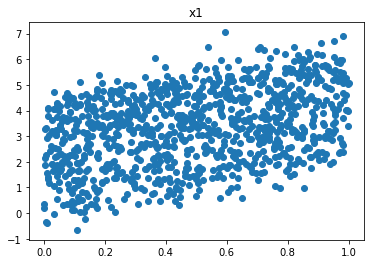

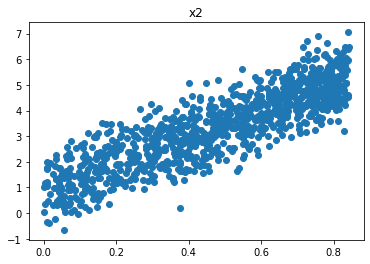

In [3]:
for col in data_df.iloc[:, :-1]:
    plt.figure()
    plt.title(col)
    plt.scatter(data_df[col], y)
    plt.show()

In [4]:
from sklearn.linear_model import LinearRegression

X = data_df.iloc[:, :-1].values
y = data_df.iloc[:, -1].values
my_lr = LinearRegression().fit(X,y)

print(my_lr.score(X,y))
print(my_lr.coef_, my_lr.intercept_)

0.8872459299623613
[1.99669626 5.22694591] -0.09651741191430929


In [7]:
def model(X, y):
    
    #print("sample coef")
    beta_0 = pyro.sample("beta_0", dist.Uniform(0.0, 8.0))
    
    mean = beta_0
    for i in range(X.shape[1]):
        beta_i = pyro.sample(f"beta_{i+1}", dist.Uniform(0.0, 8.0))
        mean = mean + beta_i * X[:, i]
    
    
    sigma = pyro.sample("sigma", dist.Uniform(0.0, 8.0))
    
    
    with pyro.plate("data", len(y)):
        observation = pyro.sample(f"obs", dist.Normal(mean, sigma), obs=y)

In [8]:
from pyro.infer import MCMC, NUTS


pyro.clear_param_store()
my_kernel = NUTS(model)


my_mcmc = MCMC(my_kernel,
               num_samples=2000,
               warmup_steps=100)

X_torch = torch.tensor(X)
y_torch = torch.tensor(y)

start_time = time.time()
my_mcmc.run(X_torch,y_torch)
end_time = time.time()

print(f'took {round(end_time -  start_time, 2)} seconds')

Sample: 100%|██████████| 2100/2100 [01:16, 27.55it/s, step size=9.98e-02, acc. prob=0.961]

took 76.24 seconds


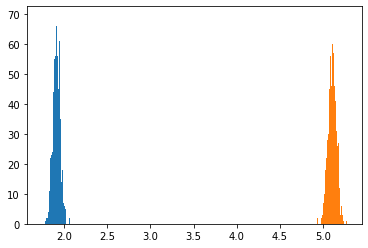

In [9]:
plt.figure()
plt.hist(my_mcmc.get_samples()['beta_1'], bins=100)
plt.hist(my_mcmc.get_samples()['beta_2'], bins=100)
plt.show()

In [10]:
my_mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0      0.02      0.01      0.01      0.00      0.03    525.35      1.00
    beta_1      1.91      0.04      1.91      1.84      1.99   1405.81      1.00
    beta_2      5.11      0.05      5.11      5.03      5.19   1511.03      1.00
     sigma      0.50      0.01      0.50      0.48      0.51   1295.20      1.00

Number of divergences: 0


In [ ]:
beta_0_samples = my_mcmc.get_samples()['beta_0'].numpy().reshape(-1, 1)
beta_0_samples.shape

In [ ]:
beta_1_samples = my_mcmc.get_samples()['beta_1'].numpy().reshape(-1, 1)
beta_1_samples.shape

In [ ]:
beta_2_samples = my_mcmc.get_samples()['beta_2'].numpy().reshape(-1, 1)
beta_2_samples.shape

In [ ]:
X.shape

In [ ]:
y_new = beta_0_samples + beta_1_samples * 0.5 + beta_2_samples * 1.0 

In [ ]:
y_new.shape

In [ ]:
plt.figure()
plt.hist(y_new, bins=50)
plt.show() 